<div align="center">
  <h1 style="color: skyblue;">
    Quantum Tree Generator for Quantum Approximate Optimization Algorithm (QTG-QAOA) for the Quadratic Knapsack Problem (QKP)
  </h1>
</div>


## 📘 Introduction: Quantum Tree Generator and Constraint-Preserving QAOA for 0-1 QKP

<div style="border-left: 4px solid #4CAF50; padding-left: 1em;">
    <span style="color: #4CAF50; font-weight: bold;">This notebook provides a concise technical overview</span> of the implementation of the <span style="color: #2196F3; font-weight: bold;">Quantum Tree Generator (QTG)</span>, originally introduced by Sören Wilkening et al. in <em>"A Quantum Algorithm for Solving 0–1 Knapsack Problems"</em>. The purpose of the QTG is to generate a feasible quantum state, i.e., a superposition of bitstrings that satisfy the capacity constraint of the 0–1 knapsack problem and then implement a quantum search based on quantum grover algorithm. This works is inspired by the work of Paul Christiansen et al. in <em>"Quantum tree generator improves QAOA state-of-the-art for the knapsack problem"</em>, which extends the QTG to the Lineal Knapsack Problem (QKP) and integrates it with the Quantum Approximate Optimization Algorithm (QAOA).
</div>

### 🎯 Goal
To encode feasibility directly into the initial state of the quantum algorithm. This guarantees that any quantum evolution will remain within the feasible subspace — a key requirement when applying QAOA to combinatorial optimization problems with hard constraints.

### 🧩 Quantum Tree Generator (QTG)
The QTG is a quantum circuit that builds a superposition of feasible knapsack solutions using a recursive tree structure, where amplitude is assigned only to those branches (bitstrings) that respect the weight constraint. This method scales efficiently for problems of moderate size and eliminates the need for costly penalty terms in the Hamiltonian.

### 🔧 Mixer Construction
We use the approach proposed by Franz Georg Fuchs et al. in <em>"Constraint Preserving Mixers for the Quantum Approximate Optimization Algorithm"</em>, which extends the QAOA framework by constructing customized mixers that preserve the feasible subspace. By acting only on feasible states, the constraint-preserving mixer ensures that the quantum evolution induced by the QAOA ansatz remains within the feasible region throughout the optimization process.

### 📌 Context
This setup is applied to the <span style="color:#E91E63; font-weight:bold;">Quadratic Knapsack Problem (QKP)</span>, a generalization of the classical 0–1 Knapsack Problem where the profit function includes quadratic terms. The QAOA framework allows for encoding such problems via a cost Hamiltonian (derived from profit interactions) and a constraint-aware mixer (as above), enabling near-term quantum devices to approximate solutions.

---

> 🔬 This implementation combines classical preprocessing (e.g., generating valid solutions) with quantum operations, using Qiskit for circuit design and execution. The goal is to explore how constraint-preserving dynamics improve solution quality and convergence speed in quantum combinatorial optimization.

### 📌 Requirements
To run this notebook, you need to have the Qiskit library installed. You can install it using pip:

```bash
    pip install qiskit
```


---
<div align="center">
  <h1 style="color: white;">
    START OF THE NOTEBOOK
  </h1>
</div>

## 📂 Instances

Ussually, the QKP instances are generated using the `generate_and_save_instance` function from the `QKP.instances_generator` module. This function creates a random instance of the QKP with specified parameters such as the number of items, capacity, and percentage of non-zero profit entries. But for this notebook, we will use the following instance as an example:

In [205]:
import numpy as np

n_items = 4
weights = [1, 1, 1, 1]
profits = np.array([[7, 1, 3, 0],
                    [1, 1, 5, 1],
                    [3, 5, 7, 4],
                    [0, 1, 4, 1]]
                    )
capacity = 2

## 🌳 Quantum Tree Generator (QTG) 
The QTG is implemented in the `QKP.qtg_builder` module, which contains the `QTG` class. This class is responsible for generating a quantum circuit that encodes the feasible solutions of the QKP instance. Note that QTG circuit contains more qubits than the number of items in the QKP instance, as it uses additional qubits to encode the feasibility constraints (ancilla qubits). Unlike the original proposal of the QTG, which use the register for carry the profit, in this case, we will use just the register to carry the weight of the knapsack like Paul Christiansen et al. in <em>"Quantum tree generator improves QAOA state-of-the-art for the knapsack problem"</em>.

---
As is proposed by Sören Wilkening et al. is useful implement an intermedate solution for to bias the QTG circuit towards optimal solutions. The biased factor is choosen as $n/4$. 

# Here we implement a greedy algorithm to generate a intermediate solution.

In [206]:
from QKP.classical_solution import greedy_solution

greedy_ansatz = greedy_solution(n_items, weights, profits, capacity)
biased = n_items/4 

print("Greedy Ansatz:", greedy_ansatz)

Greedy Ansatz: [1, 0, 1, 0]


# Creation and measure for QTG circuit.

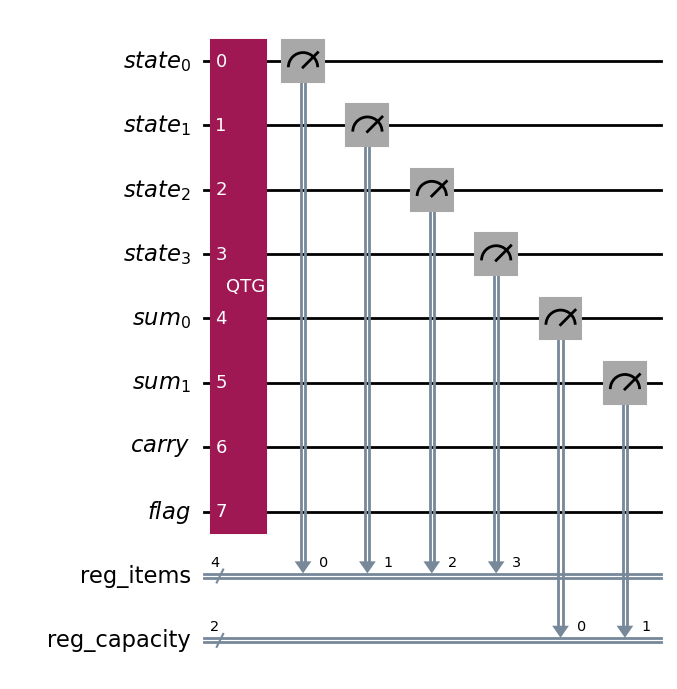

In [207]:
from qiskit import QuantumCircuit, transpile
from QTG.qtg_builder import QTG
from qiskit_aer import Aer
from qiskit.circuit import ClassicalRegister

qc_QTG = QuantumCircuit(n_items)  

qc_QTG = QTG(
        num_state_qubits=n_items,  
        weights=weights,
        y_ansatz=greedy_ansatz,  
        biased=biased,
        capacity=capacity)

reg_items = ClassicalRegister(n_items, 'reg_items')                       # Create a classical register to store the measurement results for the items 
reg_capacity = ClassicalRegister(capacity.bit_length(), 'reg_capacity')   # and capacity
qc_QTG.add_register(reg_items, reg_capacity) 
qc_QTG.measure(qc_QTG.qubits[0:n_items], reg_items)
qc_QTG.measure(qc_QTG.qubits[n_items:n_items+capacity.bit_length()], reg_capacity) 

qc_QTG.draw('mpl')

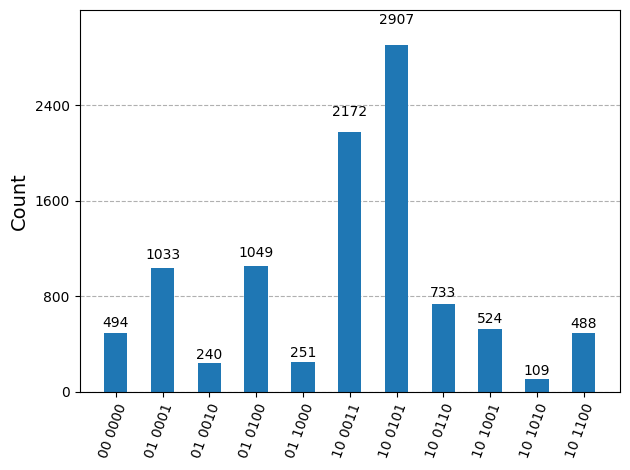

In [208]:
from collections import defaultdict
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(qc_QTG, simulator)

# Execute the circuit
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

Note that the capacity is never exceeded (3 correspond 11 in binary). Basically the items selection in the example is all the possible ways to choose 2 items out of a total of 4, since each one weighs 1. And also note that the probability of the biased state given by the greedy solution has increased to a greater extent.

## Creation of the Feasible State

Unlike the proposal of Christiansen et al. for use the QTG circuit as initial state and the QTG routine for the mixer operator in the QAOA, in this case we will use the measurement of the QTG circuit to obtain the feasible states and then prepare the initial circuit and build the constraint-preserving mixer for the QAOA in based of this measurements, since this **consumes less quantum computing resources** than the original proposal.

---
The `build_feasible_state` takes as input the counts of measurements from the QTG circuit and constructs a feasible quantum state assigning probabilities to each feasible solution. This circuit is then used as the initial state for the QAOA algorithm.

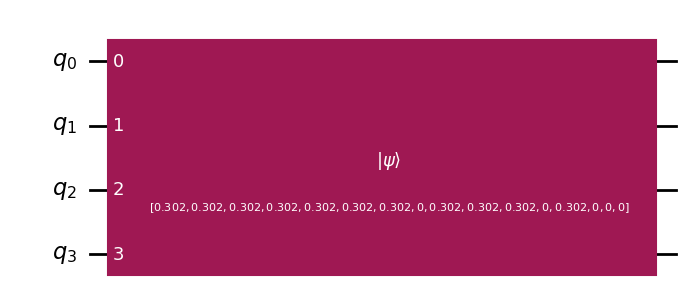

In [209]:
from QTG.feasible_circuit import build_feasible_circuit

# Obtain the feasible states for the items from the counts
feasible_states = {}

for full_bitstring, count in counts.items():
    clean_bitstring = full_bitstring.replace(" ", "")
    items_bits = clean_bitstring[-n_items:]

    feasible_states[items_bits] = feasible_states.get(items_bits, 0) + count

qc_feasible = build_feasible_circuit(feasible_states, uniform=True) # In this case, we use the uniform=True option to create a uniform superposition of the feasible states.
qc_feasible.draw('mpl')

## Construction of constraint-preserving mixer for QAOA

The `build_constraint_preserving_mixer` function constructs a mixer operator that preserves the feasible subspace of QKP based on knowing the feasible space, as proposed by Franz Georg Fuchs et al. in <em>"Constraint Preserving Mixers for the Quantum Approximate Optimization Algorithm"</em>. 


In [210]:
from QAOA.constraint_mixer import build_constraint_mixer_operator

constraint_mixer = build_constraint_mixer_operator(
    states_dict=feasible_states,
    strategy="hamming1",
    weight=1.0,
    sparse=True
)
print("Constraint Preserving Mixer: ", constraint_mixer)

Constraint Preserving Mixer:  SparsePauliOp(['IIIX', 'IIXI', 'IIXZ', 'IIZX', 'IXII', 'IXIZ', 'IXZI', 'IZIX', 'IZXI', 'XIII', 'XIIZ', 'XIZI', 'XZII', 'XZZZ', 'ZIIX', 'ZIXI', 'ZXII', 'ZXZZ', 'ZZXZ', 'ZZZX'],
              coeffs=[ 0.5 +0.j,  0.5 +0.j,  0.25+0.j,  0.25+0.j,  0.5 +0.j,  0.25+0.j,
  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.5 +0.j,  0.25+0.j,  0.25+0.j,
  0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,
 -0.25+0.j, -0.25+0.j])


Up to this point we haven't used the profits matrix $Q$ (except the greedy solution but this is not strictly necessary), since the preparation of the initial state and the constraint mixer only depend on the problem restriction, that is, the capacity and the weights, therefore this procedure would be unique for the same instance independent of the utility matrix $Q$. That means, this **state and mixer is recyclable** for an similar instance with a different Q.

## 📈 QAOA Implementation

Here we will build the hamiltonian to otpimize in based of the profits matrix $x^T Q x$ using the `QAOA.qaoa.build_qkp_cost_hamiltonian` function, and then prepare the QAOA circuit using the feasible state as the initial circuit and the constraint-preserving mixer. Note that the hamiltonian is unconstrained like QUBO problems.

In [211]:
from QAOA.qaoa import build_qkp_cost_hamiltonian

cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, profits)
print("Cost Hamiltonian: ", cost_hamiltonian)

Cost Hamiltonian:  SparsePauliOp(['IIIZ', 'IIZZ', 'IZIZ', 'IIZI', 'IZZI', 'ZIZI', 'IZII', 'ZZII', 'ZIII'],
              coeffs=[ 3.75+0.j, -0.5 +0.j, -1.5 +0.j,  3.75+0.j, -2.5 +0.j, -0.5 +0.j,
  7.75+0.j, -2.  +0.j,  2.75+0.j])


Now all that remains is to use Qiskit's QAOAAnsatz function to solve the problem. The optimization is performed only in the feasible space, so the solution must satisfy the constraint.

In [212]:
from qiskit.circuit.library import QAOAAnsatz

reps = 1  # Number of layers in the QAOA circuit

qaoa= QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    mixer_operator=constraint_mixer,
    initial_state=qc_feasible,
    reps=reps,
    name="QAOA_QKP" 
)

The fllowing is parameter optimization for QAOA using the `minimize` function from `scipy.optimize`. The optimization is performed using the COBYLA method, which is a derivative-free optimization algorithm. The objective function is the expectation value of the cost Hamiltonian with respect to the QAOA circuit.


In [213]:
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps

objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=10_000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params, inplace=False)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(qaoa, cost_hamiltonian, estimator),
    method="COBYLA", 
    tol=1e-10,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.95135
       x: [ 4.669e+00  1.256e+00]
    nfev: 67
   maxcv: 0.0


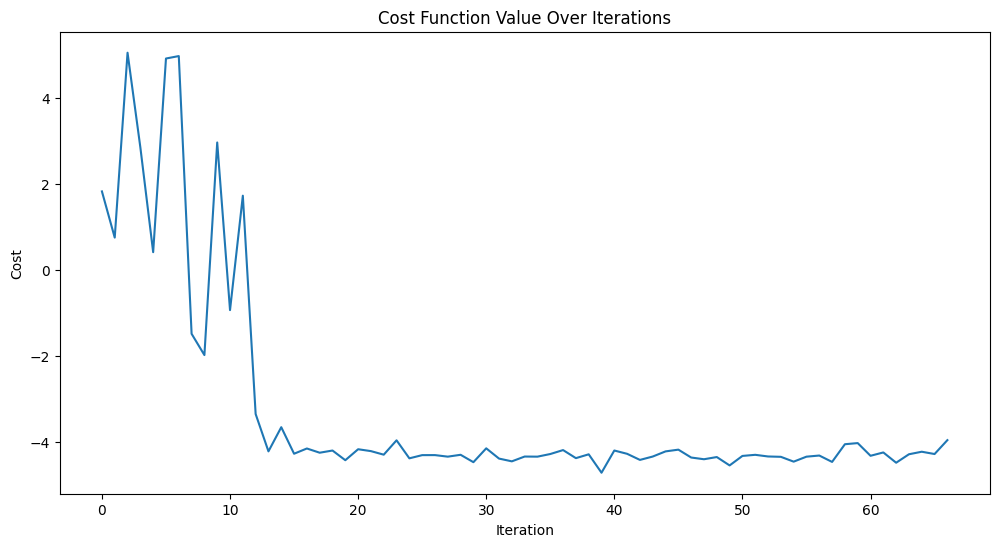

In [214]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function Value Over Iterations")
plt.show()

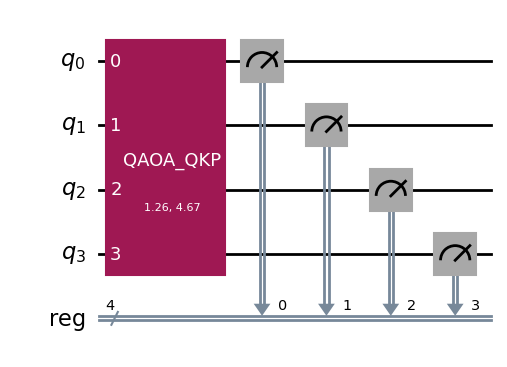

In [215]:
optimized_circuit = qaoa.assign_parameters(result.x)   # Assign the optimized parameters to the QAOA circuit and measure the qubits
reg = ClassicalRegister(n_items, 'reg')
optimized_circuit.add_register(reg)
optimized_circuit.measure(qaoa.qubits[0:n_items], reg)
optimized_circuit.draw('mpl')

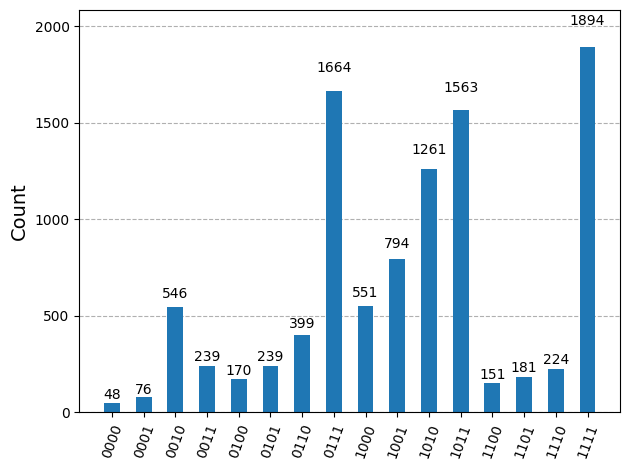

In [216]:
# Execute the optimized circuit
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

counts = result.get_counts()
plot_histogram(counts)

In [ ]:
from QKP.classical_solution import solve_qkp_cplex

most_probable_solution = max(counts.items(), key=lambda kv: kv[1])
print("Most probable solution:", most_probable_solution)   


Most probable solution: ('1111', 1894)
